<a href="https://colab.research.google.com/github/shokru/carbon_emissions/blob/main/carbon_funds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Green vs conventional assets: a comparison

This notebook seeks to compare the performance of traditional versus green investment vehicles.

We download data from **Yahoo Finance**, which requires the installation of a dedicated Python module:

In [1]:
!pip install yfinance # If need be... yfinance serves to import financial data 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 3.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.covariance import LedoitWolf
import plotly.io as pio
import yfinance as yf
pd.set_option('display.max_rows', 6)     # First 3 and last 3 rows will be shown

## Import the data
Then, let's import the data from Yahoo Finance. 
We consider 2 tickers, and merge the 2 resulting dataframes into the object **data**.  
The first ticker is **SPY**, which is an ETF on the S&P500: it is a proxy for the US equity market.  
The second one (**SUSA**) stands from *iShares MSCI USA ESG Select ETF*, and will proxy for the *green* equivalent of the traditional market.

In [3]:
spy = yf.Ticker("SPY")
susa = yf.Ticker("SUSA")

data = susa.history(start="2005-01-28", end="2023-01-30").assign(Ticker = 'SUSA').append(
       spy.history(start="2005-01-28", end="2023-01-30").assign(Ticker = 'SPY'))
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Ticker
Date,,,,,,,,,
2005-01-28 00:00:00-05:00,19.123934,19.123934,19.020891,19.020891,2600,0.0,0.0,0.0,SUSA
2005-01-31 00:00:00-05:00,19.207892,19.219341,19.200259,19.211708,10400,0.0,0.0,0.0,SUSA
2005-02-01 00:00:00-05:00,19.272774,19.406347,19.272774,19.383450,2200,0.0,0.0,0.0,SUSA
...,...,...,...,...,...,...,...,...,...
2023-01-25 00:00:00-05:00,395.950012,400.700012,393.559998,400.350006,84800300,0.0,0.0,0.0,SPY
2023-01-26 00:00:00-05:00,403.130005,404.920013,400.029999,404.750000,72287400,0.0,0.0,0.0,SPY
2023-01-27 00:00:00-05:00,403.660004,408.160004,403.440002,405.679993,68280700,0.0,0.0,0.0,SPY


# First plots

Let's have a look!

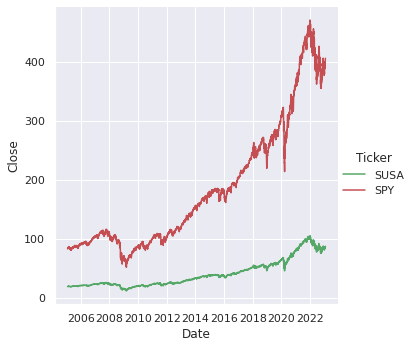

In [4]:
sns.set_theme()
sns.relplot(
    data = data.reset_index(),   # Data source = the data object
    kind = "line",               # Graph type = line
    x = "Date",                  # x-axis = Date column (of course!)
    y = "Close",                 # y-axis = Close column
    hue = "Ticker",              # One color for each asset
    palette=["g", "r"]           # Green for the green asset!
)

Both curves are hard to compare because they do not start at the same value!

We must normalize them. We do so by introducing a new column, the normalized close price, 'N_Close'. 

In [5]:
data['N_Close'] = data.groupby('Ticker')['Close'].transform(lambda x: x/x[0])
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Ticker,N_Close
Date,,,,,,,,,,
2005-01-28 00:00:00-05:00,19.123934,19.123934,19.020891,19.020891,2600,0.0,0.0,0.0,SUSA,1.000000
2005-01-31 00:00:00-05:00,19.207892,19.219341,19.200259,19.211708,10400,0.0,0.0,0.0,SUSA,1.010032
2005-02-01 00:00:00-05:00,19.272774,19.406347,19.272774,19.383450,2200,0.0,0.0,0.0,SUSA,1.019061
...,...,...,...,...,...,...,...,...,...,...
2023-01-25 00:00:00-05:00,395.950012,400.700012,393.559998,400.350006,84800300,0.0,0.0,0.0,SPY,4.831118
2023-01-26 00:00:00-05:00,403.130005,404.920013,400.029999,404.750000,72287400,0.0,0.0,0.0,SPY,4.884214
2023-01-27 00:00:00-05:00,403.660004,408.160004,403.440002,405.679993,68280700,0.0,0.0,0.0,SPY,4.895437


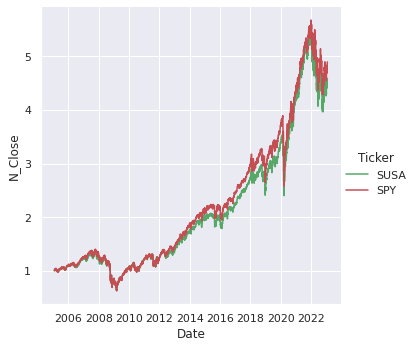

In [6]:
sns.set_theme()
sns.relplot(
    data = data.reset_index(),  # Data source = the data object
    kind = "line",              # Graph type = line
    x = "Date",                 # x-axis = Date column (of course!)
    y = "N_Close",              # y-axis = the normalised Close column
    hue = "Ticker",             # One color for each asset
    palette=["g", "r"]          # Green for the green asset!
)

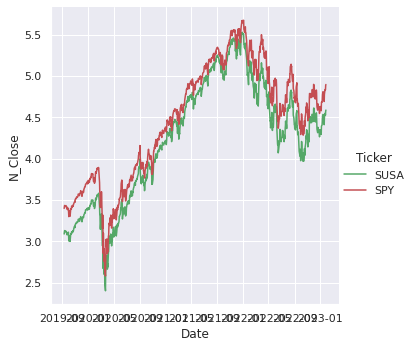

In [8]:
sns.set_theme()
sns.relplot(
    data = data.reset_index().query('Date > "2019-09-09 00:00:00-05:00"'),  # Data source = the data object
    kind = "line",              # Graph type = line
    x = "Date",                 # x-axis = Date column (of course!)
    y = "N_Close",              # y-axis = the normalised Close column
    hue = "Ticker",             # One color for each asset
    palette=["g", "r"]          # Green for the green asset!
)

The two curves are very close!
This is a first hint that sustainable investing is not much different from traditional investing.

## Working on returns
To deepen the analysis, we must look at returns.
We add the year column to ease the computation of pivot tables.

In [9]:
data['Return'] = data['Close'] / data.groupby('Ticker')['Close'].shift(1) - 1
data['Year'] = data.index.year
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Ticker,N_Close,Return,Year
Date,,,,,,,,,,,,
2005-01-28 00:00:00-05:00,19.123934,19.123934,19.020891,19.020891,2600,0.0,0.0,0.0,SUSA,1.000000,NaN,2005
2005-01-31 00:00:00-05:00,19.207892,19.219341,19.200259,19.211708,10400,0.0,0.0,0.0,SUSA,1.010032,0.010032,2005
2005-02-01 00:00:00-05:00,19.272774,19.406347,19.272774,19.383450,2200,0.0,0.0,0.0,SUSA,1.019061,0.008939,2005
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-25 00:00:00-05:00,395.950012,400.700012,393.559998,400.350006,84800300,0.0,0.0,0.0,SPY,4.831118,0.000375,2023
2023-01-26 00:00:00-05:00,403.130005,404.920013,400.029999,404.750000,72287400,0.0,0.0,0.0,SPY,4.884214,0.010990,2023
2023-01-27 00:00:00-05:00,403.660004,408.160004,403.440002,405.679993,68280700,0.0,0.0,0.0,SPY,4.895437,0.002298,2023


We then proceed to a pivot table in which we compute, for each calendar year, the **average daily return** over each index.
We plot the result immediately. The pivot table is coded in the complex row.

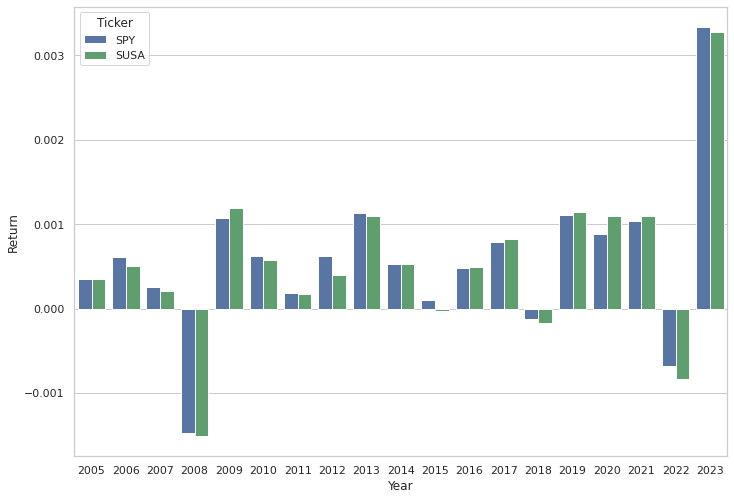

In [10]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
sns.barplot(
    data = data.dropna().pivot_table(values = 'Return', index = ['Ticker','Year'], aggfunc = np.mean).reset_index(),
    x = "Year",         # x-axis = Year column 
    y = "Return",       # y-axis = the average return
    hue = "Ticker",     # One color for each asset
    palette=['b', 'g']  # Green for the green asset!
)

This confirms that the two indices are relatively close. An interesting remark is 

that the green index performs better than the traditional one after major crises, e.g., in 2009 (post subprime turmoil) and in 2020-2021 (post Covid crash).


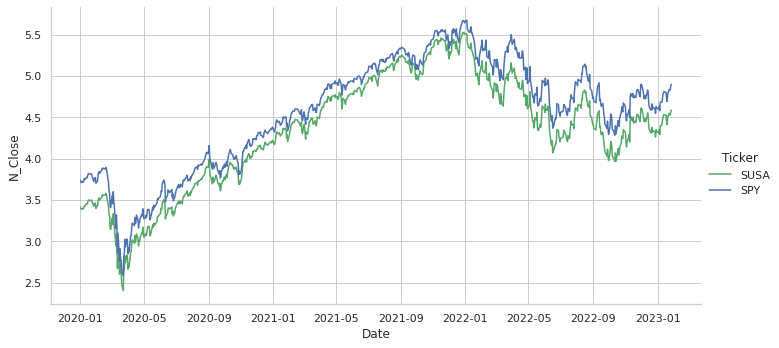

In [12]:
sns.set_style("whitegrid")
sns.relplot(
    data = data.reset_index().query('Date > "2019-12-31 00:00:00-05:00"'),     # Data source = the data object
    kind = "line",      # Graph type = line
    x = "Date",         # x-axis = Date column (of course!)
    y = "N_Close",      # y-axis = the normalised Close column
    hue = "Ticker",     # One color for each asset
    palette=["g", "b"], # Green for the green asset!
    aspect = 2
)


The S&P was higher above the green index before the Covid-19 crisis...  
The "**safe haven**" property of green assets is still debated among academics & practitioners.
Let's have a dynamic look at volatility.

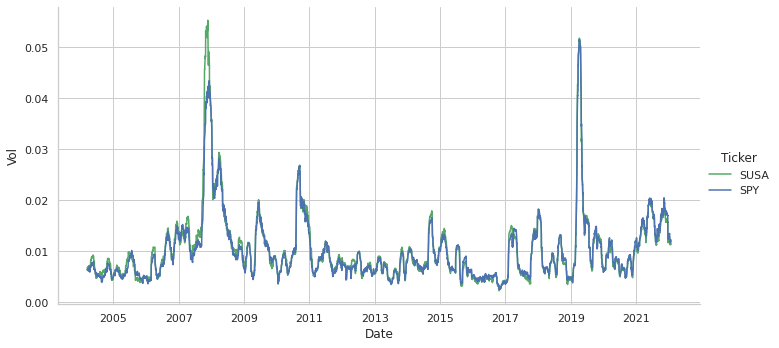

In [13]:
sns.set_style("whitegrid")
data = data.reset_index()
data['Vol'] = data.groupby('Ticker')['Return'].rolling(30).std().reset_index()['Return']
sns.relplot(
    data = data.reset_index(),        # Data source = the data object
    kind = "line",      # Graph type = line
    x = "Date",         # x-axis = Date column (of course!)
    y = "Vol",          # y-axis = the normalised Close column
    hue = "Ticker",     # One color for each asset
    palette=["g", "b"], # Green for the green asset!
    aspect = 2
)

The only major shift was during the subprime crisis: the green fund was riskier!  
This was not true in 2020...